In [49]:
import xarray as xr
from pcv.process import select_data
from pcv.cfg import IPCC_REGION_SHPFILE

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os


In [62]:
t2m_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_t2m.nc"
tp_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_tp.nc"
ssrd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_ssrd.nc"
lai_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_lai.nc"
swvlall_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_smroot.nc"
vpd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_vpd.nc"
sd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_sd.nc"

t2m_data = xr.open_dataset(t2m_path)
tp_data = xr.open_dataset(tp_path)
ssrd_data = xr.open_dataset(ssrd_path)
swvlall_data = xr.open_dataset(swvlall_path)
vpd_data = xr.open_dataset(vpd_path)
sd_data = xr.open_dataset(sd_path)
lai_data = xr.open_dataset(lai_path)
lai_data = lai_data.reindex(lat = list(reversed(lai_data.lat)))

In [75]:
t2m_winter = select_data(t2m_data,  "winter")
t2m_spring = select_data(t2m_data,  "spring")
t2m_summer = select_data(t2m_data,  "summer")

tp_winter = select_data(tp_data,  "winter")
tp_spring = select_data(tp_data,  "spring")
tp_summer = select_data(tp_data,  "summer")

ssrd_winter = select_data(ssrd_data,  "winter")
ssrd_spring = select_data(ssrd_data,  "spring")
ssrd_summer = select_data(ssrd_data,  "summer")

lai_winter = select_data(lai_data,  "winter")
lai_spring = select_data(lai_data,  "spring")
lai_summer = select_data(lai_data,  "summer")

swvlall_winter = select_data(swvlall_data,  "winter")
swvlall_spring = select_data(swvlall_data,  "spring")
swvlall_summer = select_data(swvlall_data,  "summer")

vpd_winter = select_data(vpd_data,  "winter")
vpd_spring = select_data(vpd_data,  "spring")
vpd_summer = select_data(vpd_data,  "summer")


sd_winter = select_data(sd_data,  "winter")
sd_spring = select_data(sd_data,  "spring")
sd_summer = select_data(sd_data,  "summer")

xtreme = "high"
if xtreme=="low":
    t = lai_summer.quantile(0.1, dim="time")
    lai_summer = xr.where(lai_summer<t, 1, 0)
elif xtreme == "high":
    t = lai_summer.quantile(0.9, dim="time")
    lai_summer = xr.where(lai_summer>t, 1, 0)


/home/anand/.conda/envs/pcv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [76]:
def read_clim_mask():
    clim_mask_path = "/data/compoundx/anand/PCV/data/clim_mask/"
    clim_files = [clim_mask_path + file for file in os.listdir(clim_mask_path) if ".npy" in file ]

    return [np.load(files) for files in clim_files], [files.split("/")[-1] for files in clim_files]

def read_land_use(year):
    if year < 2016:
        version = "2.0.7cds"
    else:
        version = "2.1.1"

    file_name = f"/data/compoundx/anand/PCV/data/CCI-LC/ESACCI-LC-L4-LCCS-Map-300m-P1Y-aggregated-0.500000Deg-{year}-v{version}.nc"
    return xr.open_dataset(file_name)

def majority_class_1_landuse():
    val = []
    for i in range(1992, 2019):
        data = read_land_use(i)
        val.append(data.interp(lat = lai_data.lat.data, lon = lai_data.lon.data, method = "nearest").majority_class_1.data)

    majority_class_1 = np.stack(val)

    lu_mc_1 = xr.DataArray(
        majority_class_1, dims = ["time", "lat", "lon"], coords = {
            "time" : np.arange(1992, 2019),
            "lat" : lai_data.lat.data,
            "lon" : lai_data.lon.data,
        }
    )
    return lu_mc_1

lu_mc_1 = majority_class_1_landuse()

def mask_crop_forest(lu_mc_1):

    last_year_lu = lu_mc_1[-1,:,:]
    
    mask_forest = ((last_year_lu>=40) & ((last_year_lu<110)))
    mask_crop = ((last_year_lu>=10) & ((last_year_lu<40)))

    return mask_crop.values, mask_forest.values

In [77]:
mask_crop, mask_forest = mask_crop_forest(lu_mc_1)
region_mask, region_name = read_clim_mask()

In [78]:
def generate_shape_feature():
    ipcc_regions = shpreader.Reader(IPCC_REGION_SHPFILE)
    shape_feature_list = []
    for i, records in enumerate(ipcc_regions.records()):
        shape_feature = ShapelyFeature([records.geometry], ccrs.PlateCarree(), facecolor = "None", edgecolor='black', lw=1)
        shape_feature_list.append((records.attributes["Name"], shape_feature, (records.geometry.centroid.x, records.geometry.centroid.y) ))

    return shape_feature_list
shape_feature_list = generate_shape_feature()

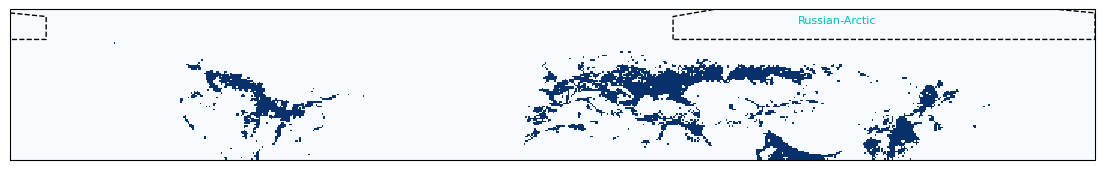

In [79]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8), 
                subplot_kw={'projection': ccrs.PlateCarree()})

ax.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), np.flip(mask_crop, axis=0), snap=True, cmap = "Blues")

for name, shape_feature, centroid in shape_feature_list:
    # if 75>centroid[1]>15:
    if name in ["Russian-Arctic"]: #["W.C.Asia", "E.C.Asia", "W.Siberia", "Tibetan-Plateau"]: 
        ax.add_feature(shape_feature, linestyle = "--", label = name)
        ax.set_extent((-180, 180, 25, 75), crs=ccrs.PlateCarree())
        ax.text(centroid[0], centroid[1], name, color='c', size=8, ha='center', va='center', wrap = True,  transform=ccrs.PlateCarree())

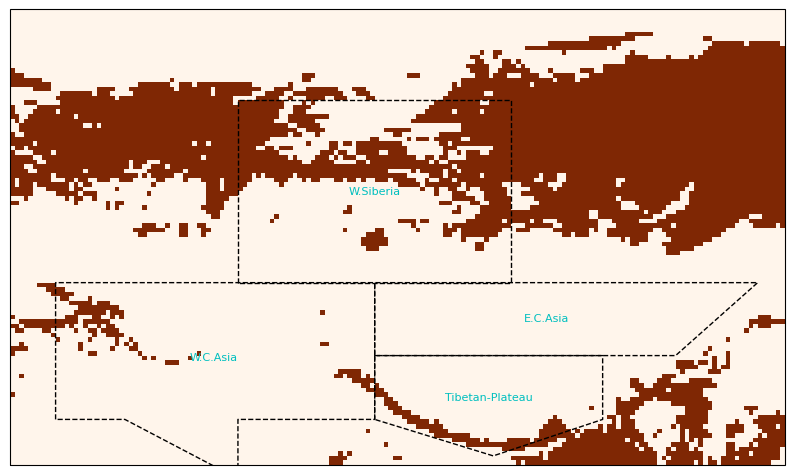

In [80]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8), 
                subplot_kw={'projection': ccrs.PlateCarree()})

ax.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), np.flip(mask_forest, axis=0), snap=True, cmap = "Oranges")

for name, shape_feature, centroid in shape_feature_list:
    # if 75>centroid[1]>15:
    if name in ["W.C.Asia", "E.C.Asia", "W.Siberia", "Tibetan-Plateau"]: 
        ax.add_feature(shape_feature, linestyle = "--", label = name)
        ax.set_extent((35, 120, 25, 75), crs=ccrs.PlateCarree())
        ax.text(centroid[0], centroid[1], name, color='c', size=8, ha='center', va='center', wrap = True,  transform=ccrs.PlateCarree())

In [81]:
def flatten_groups(arr, region_mask, mask_crop, mask_forest):

    region_crop = np.logical_and(region_mask, mask_crop)
    region_forest = np.logical_and(region_mask, mask_forest)
    
    crop = arr.values[:,region_crop==True]
    forest = arr.values[:,region_forest==True]

    year_c = np.tile(np.arange(1983,2021), crop.shape[1])
    year_f = np.tile(np.arange(1983,2021), forest.shape[1])

    return (crop.flatten("F"), year_c ), (forest.flatten("F"), year_f)

In [82]:
ds_path = "/data/compoundx/anand/PCV/data/"

for clim_index, name in enumerate(region_name):



    (t2m_w_crop, year_c), (t2m_w_forest, year_f)= flatten_groups(t2m_winter, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (tp_w_crop,_),(tp_w_forest, _) = flatten_groups(tp_winter, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))


    (t2m_sp_crop,_) , (t2m_sp_forest, _) = flatten_groups(t2m_spring, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (tp_sp_crop,_) , (tp_sp_forest, _) = flatten_groups(tp_spring, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))

    (t2m_su_crop,_) , (t2m_su_forest, _) = flatten_groups(t2m_summer, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (tp_su_crop,_) , (tp_su_forest, _) = flatten_groups(tp_summer, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))

    (sm_w_crop,_) , (sm_w_forest, _) = flatten_groups(swvlall_winter, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (sm_sp_crop,_) , (sm_sp_forest, _) = flatten_groups(swvlall_spring, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (sm_su_crop,_) , (sm_su_forest, _) = flatten_groups(swvlall_summer, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (lai_sp_crop,_) , (lai_sp_forest, _) = flatten_groups(lai_spring, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
    (lai_su_crop,_) , (lai_su_forest, _) = flatten_groups(lai_summer, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))

    x_crop = np.vstack([year_c, t2m_w_crop, tp_w_crop, sm_w_crop, t2m_sp_crop, tp_sp_crop, sm_sp_crop, lai_sp_crop, t2m_su_crop, tp_su_crop, sm_su_crop, lai_su_crop]).T
    x_forest = np.vstack([year_f, t2m_w_forest, tp_w_forest, sm_w_forest, t2m_sp_forest, tp_sp_forest, sm_sp_forest, lai_sp_forest, t2m_su_forest, tp_su_forest, sm_su_forest, lai_su_forest]).T

    header = "year\tt2m_winter\ttp_winter\tsm_winter\tt2m_spring\ttp_spring\tsm_spring\tlai_spring\tt2m_summer\ttp_summer\tsm_summer\tlai_su"

    if x_crop.shape[0]/38 > 0:
        print(name)
        np.savetxt(f"{ds_path}crop_data/{xtreme}/"+f"crop_{name[:-4]}_n_{x_crop.shape[0]//38}_v3.csv", x_crop, fmt='%1.3f', delimiter="\t", header=header)
    if x_forest.shape[0]/38 > 0:
        np.savetxt(f"{ds_path}forest_data/{xtreme}/"+f"forest_{name[:-4]}_n_{x_forest.shape[0]//38}_v3.csv", x_forest, fmt='%1.3f', delimiter="\t", header=header)


W.North-America.npy
E.Siberia.npy
Tibetan-Plateau.npy
West&Central-Europe.npy
E.Asia.npy
N.Central-America.npy
Mediterranean.npy
N.Europe.npy
Russian-Far-East.npy
N.E.North-America.npy
E.C.Asia.npy
N.W.North-America.npy
S.Asia.npy
E.Europe.npy
E.North-America.npy
C.North-America.npy
W.Siberia.npy
Sahara.npy
W.C.Asia.npy


1752.0
852.0


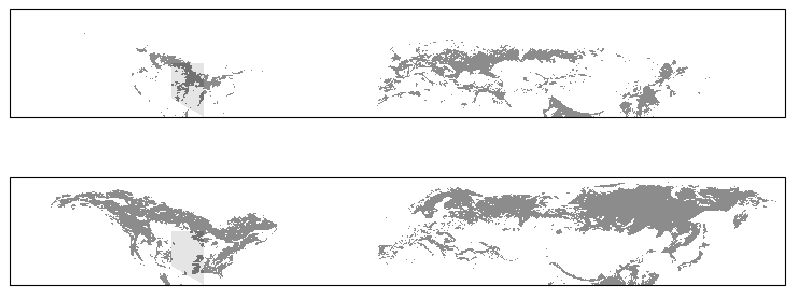

In [85]:
ds_path = "/data/compoundx/anand/PCV/data/"

for clim_index, name in enumerate(region_name):
    if name in ["C.North-America.npy"]:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 4), 
                    subplot_kw={'projection': ccrs.PlateCarree()})

        ax1.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), np.flip(mask_crop, axis=0), snap=True, alpha= 0.5, cmap="Greys")
        ax2.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), np.flip(mask_forest, axis=0), snap=True, alpha= 0.5, cmap="Greys")
        
        ax1.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), region_mask[clim_index], snap=True, alpha=0.1, cmap = "Greys")
        ax2.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), region_mask[clim_index], snap=True, alpha=0.1, cmap = "Greys")
        
        

        (t2m_w_crop, year_c), (t2m_w_forest, year_f)= flatten_groups(t2m_winter, region_mask[clim_index], mask_crop=np.flip(mask_crop, axis=0), mask_forest = np.flip(mask_forest, axis=0))
        # (tp_w_crop,_),(tp_w_forest, _) = flatten_groups(tp_winter, region_mask[clim_index], lu_mc_1)

        print(t2m_w_crop.shape[0]/38)
        print(t2m_w_forest.shape[0]/38)


In [37]:
mask_forest.shape

(200, 1440)

(200, 1440)